Run some new metrics and stackers that compare how well a survey performs relative to a survey that scans the mreidian.  For each observation, an "optimal" five-sigma limiting depth is calculated by scaling the observed five-sigma depth to account for the meridian having a lower sky brightness, smaller seeing, and less extinction. The sky brightness is only adjusted if the moon is down and there is no twilight.  

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.plots as plots
import healpy as hp
import numpy as np

In [2]:
# Set up the database connection
opsdb = db.OpsimDatabase('ewok_1004_sqlite.db')
outDir = 'optm5'
resultsDb = db.ResultsDb(outDir=outDir)

In [3]:
bundleList = []
filters = ['u','g','r','i','z','y']
slicer = slicers.HealpixSlicer(nside=64)
plotter = plots.HealpixSkyMap()
metric1 = metrics.Coaddm5Metric(m5Col='fiveSigmaDepth')
metric2 = metrics.Coaddm5Metric(m5Col='m5Optimal', metricName='Optimal m5')
summaryList = [metrics.MedianMetric()]
for filterName in filters:
    sql = 'filter="%s"' % filterName
    bundleList.append(metricBundles.MetricBundle(metric1,slicer,sql, plotFuncs=[plotter], summaryMetrics=summaryList))
    bundleList.append(metricBundles.MetricBundle(metric2,slicer,sql, plotFuncs=[plotter], summaryMetrics=summaryList))

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [4]:
bundleDict = metricBundles.makeBundlesDictFromList(bundleList)
bgroup = metricBundles.MetricBundleGroup(bundleDict, opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()

Querying database with constraint filter="y"
Found 446302 visits
Running:  ['opsim_CoaddM5_y_HEAL', 'opsim_Optimal_m5_y_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database with constraint filter="r"
Found 539071 visits
Running:  ['opsim_CoaddM5_r_HEAL', 'opsim_Optimal_m5_r_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database with constraint filter="g"
Found 247084 visits
Running:  ['opsim_Optimal_m5_g_HEAL', 'opsim_CoaddM5_g_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database with constraint filter="u"
Found 182081 visits
Running:  ['opsim_Optimal_m5_u_HEAL', 'opsim_CoaddM5_u_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database with constraint filter="i"
Found 539793 visits
Running:  ['opsim_CoaddM5_i_HEAL', 'opsim_Optimal_m5_i_HEAL

**The optimal 5$\sigma$ depth minus the actual 5$\sigma$ depth for each filter**

/Users/yoachim/lsst/DarwinX86/anaconda/2.2.0/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


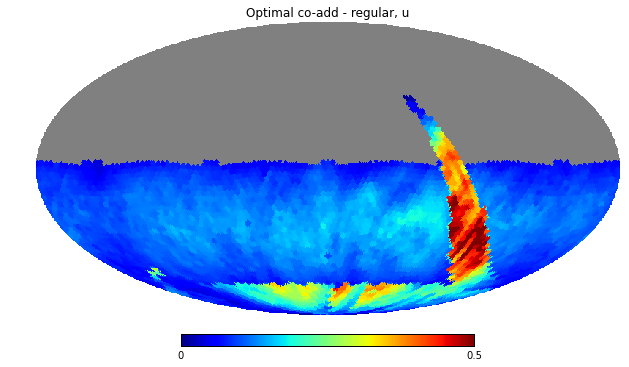

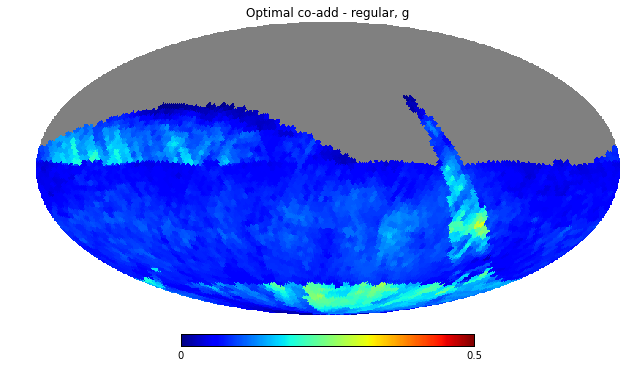

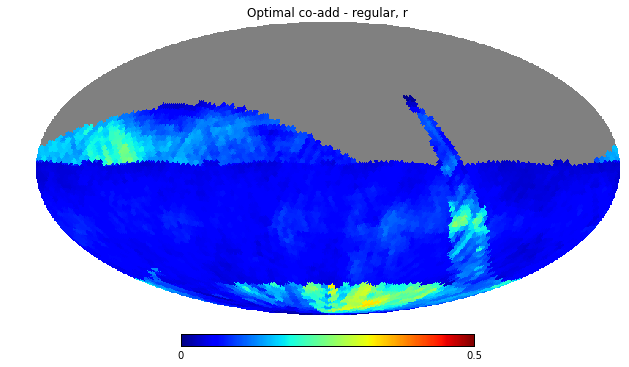

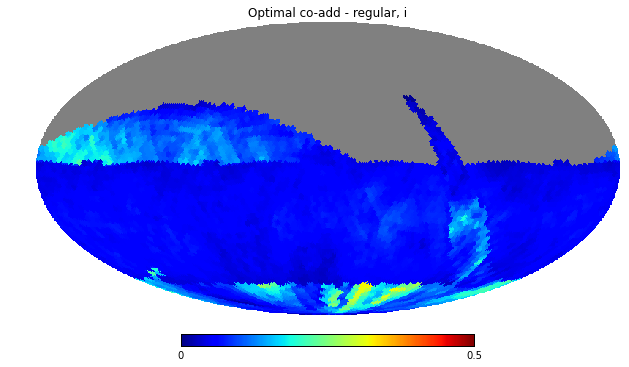

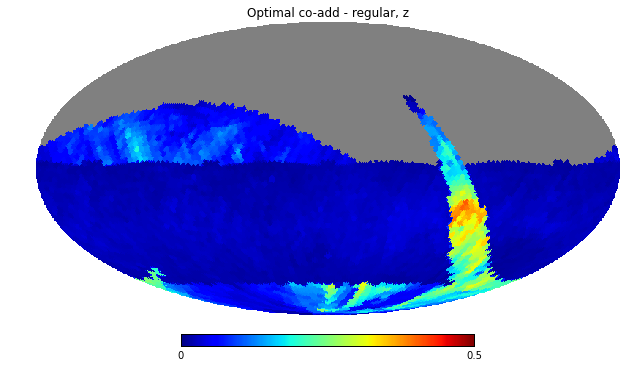

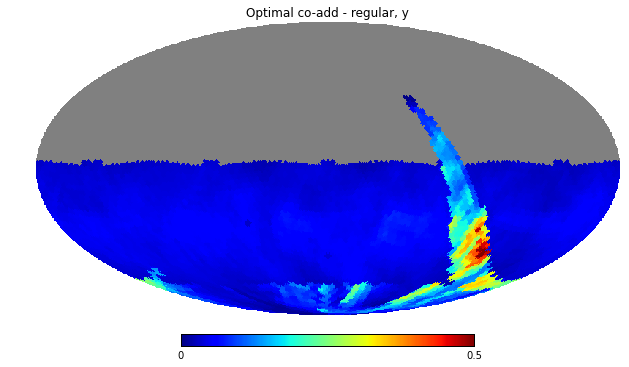

In [5]:
for i,filtername in enumerate(filters):
    newmap = bundleList[i*2+1].metricValues-bundleList[i*2].metricValues
    newmap[np.where(bundleList[i*2+1].metricValues.mask == True)] = hp.UNSEEN
    hp.mollview(newmap, 
                title='Optimal co-add - regular, %s' % filtername, min=0,max=.5)

In [6]:
print 'filter,  Optimal m5, Regular m5, diff'
for i,filtername in enumerate(filters):
    optimal = bundleList[i*2+1].summaryValues['Median']
    regular = bundleList[i*2].summaryValues['Median']
    print '%s, %.2f, %.2f, %.2f' % (filtername, optimal, regular, optimal-regular)

filter,  Optimal m5, Regular m5, diff
u, 25.57, 25.46, 0.12
g, 27.01, 26.93, 0.08
r, 27.13, 27.07, 0.06
i, 26.38, 26.32, 0.05
z, 25.20, 25.17, 0.03
y, 24.48, 24.43, 0.05


In [7]:
bundleList = []
filters = ['u','g','r','i','z','y']
slicer = slicers.HealpixSlicer(nside=64, lonCol='ditheredRA', latCol='ditheredDec')
stacker = stackers.M5OptimalStacker()
plotters = [plots.HealpixSkyMap(), plots.HealpixHistogram()]
metric1 = metrics.OptimalM5Metric()
metric2 = metrics.OptimalM5Metric(normalize=True, metricName='PercentBehind')
summaryList = [metrics.MedianMetric()]
plotDict={'colorMin':0., 'colorMax':40.}
for filterName in filters:
    sql = 'filter="%s"' % filterName
    bundleList.append(metricBundles.MetricBundle(metric1,slicer,sql, plotFuncs=plotters, 
                                                 summaryMetrics=summaryList,plotDict=plotDict,
                                                 stackerList=[stacker]))
    bundleList.append(metricBundles.MetricBundle(metric2,slicer,sql, plotFuncs=plotters, 
                                                 summaryMetrics=summaryList, plotDict=plotDict,
                                                 stackerList=[stacker]))

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


**Now for the metrics: For each filter, calculate how many more observations (taken at the median 5$\sigma$ depth) would be needed to have the survey reach the same depth as the optimal survey. Also plotting this number normalized by the number of observations that have been taken--thus, a value of 20% implies that the 10-year survey would need to run for 12 years with the current scheduler to reach the optimal 10-year depth.**

Querying database with constraint filter="y"
Found 446302 visits
Running:  ['opsim_PercentBehind_y_HEAL', 'opsim_OptimalM5_fiveSigmaDepth_m5Optimal_y_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database with constraint filter="r"
Found 539071 visits
Running:  ['opsim_PercentBehind_r_HEAL', 'opsim_OptimalM5_fiveSigmaDepth_m5Optimal_r_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database with constraint filter="g"
Found 247084 visits
Running:  ['opsim_OptimalM5_fiveSigmaDepth_m5Optimal_g_HEAL', 'opsim_PercentBehind_g_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database with constraint filter="u"
Found 182081 visits
Running:  ['opsim_PercentBehind_u_HEAL', 'opsim_OptimalM5_fiveSigmaDepth_m5Optimal_u_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Quer

Optimal bin calculation tried to make 821 bins, returning 200
Optimal bin calculation tried to make 479 bins, returning 200



Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with filter="y" sqlconstraint now.
Plotting complete.

Optimal bin calculation tried to make 261 bins, returning 200
Optimal bin calculation tried to make 593 bins, returning 200



Plotting figures with filter="r" sqlconstraint now.
Plotting complete.

Optimal bin calculation tried to make 494 bins, returning 200
Optimal bin calculation tried to make 203 bins, returning 200



Plotting figures with filter="g" sqlconstraint now.
Plotting complete.

Optimal bin calculation tried to make 325 bins, returning 200
Optimal bin calculation tried to make 1844 bins, returning 200



Plotting figures with filter="u" sqlconstraint now.
Plotting complete.

Optimal bin calculation tried to make 276 bins, returning 200
Optimal bin calculation tried to make 399 bins, returning 200



Plotting figures with filter="i" sqlconstraint now.
Plotting complete.

/Users/yoachim/lsst/DarwinX86/anaconda/2.2.0/lib/python2.7/site-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
Optimal bin calculation tried to make 355 bins, returning 200



Plotting figures with filter="z" sqlconstraint now.
Plotting complete.


Optimal bin calculation tried to make 688 bins, returning 200


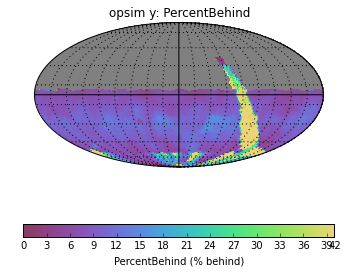

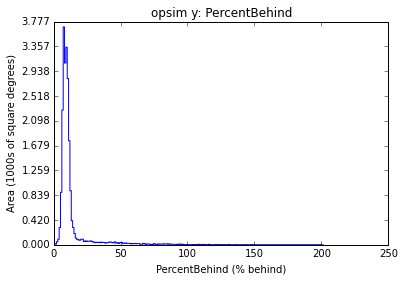

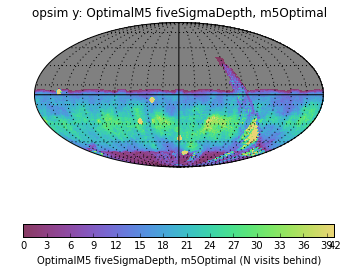

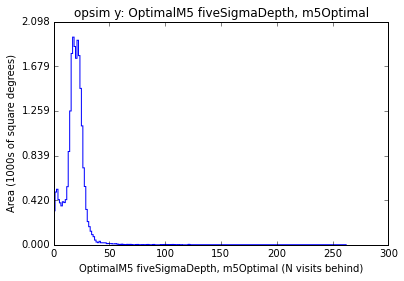

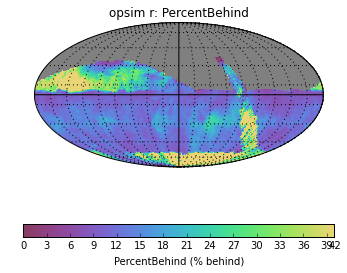

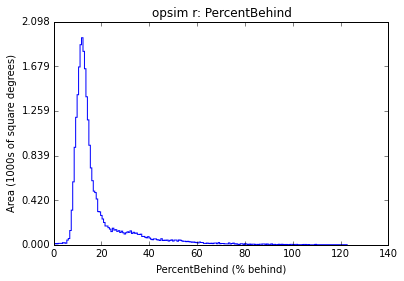

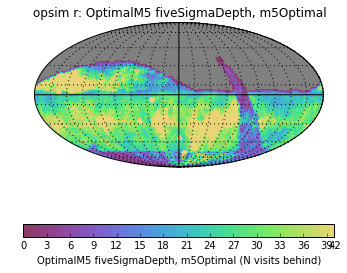

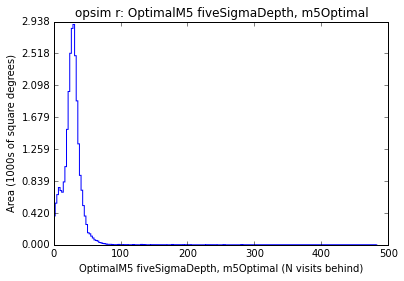

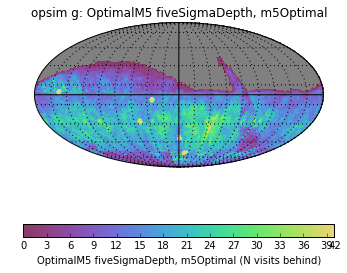

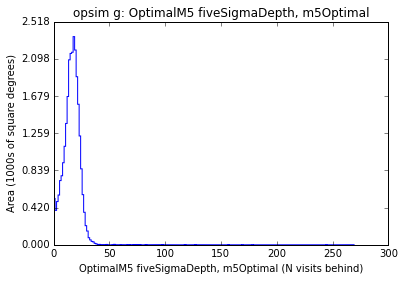

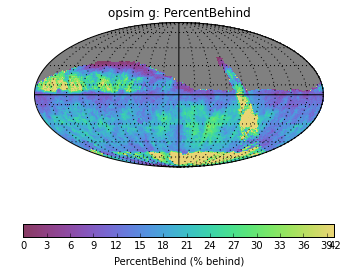

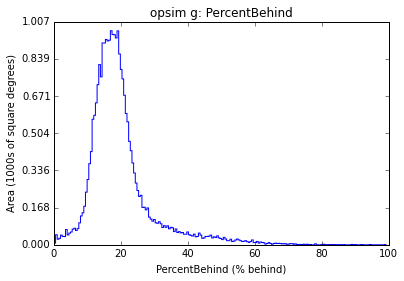

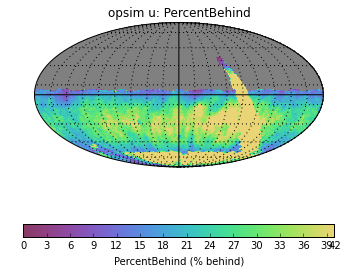

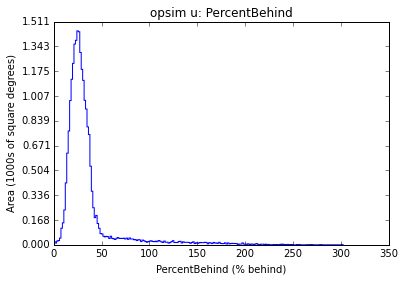

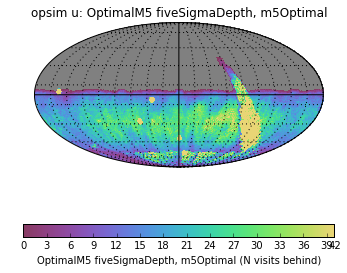

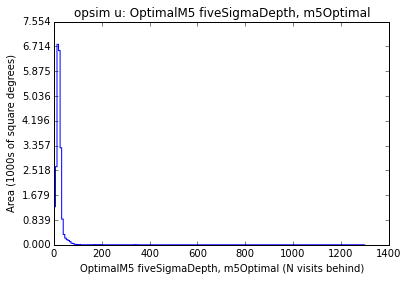

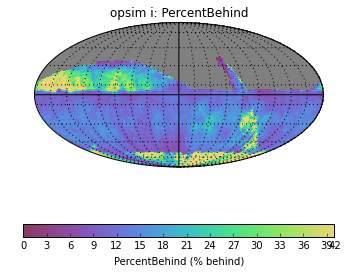

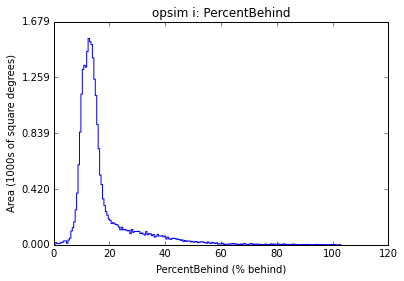

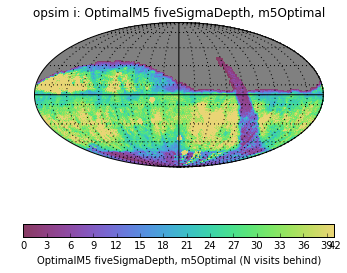

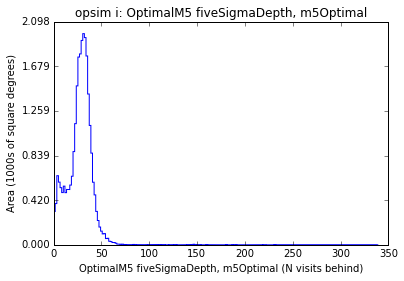

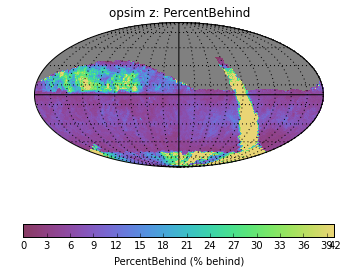

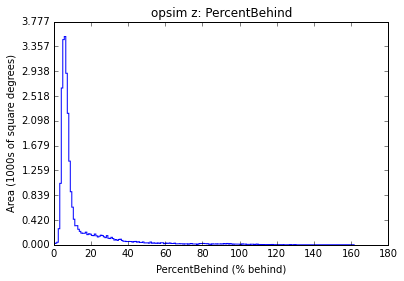

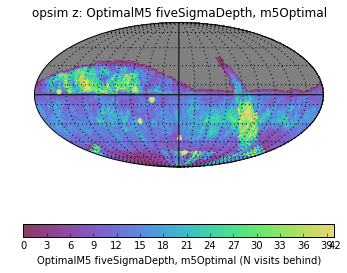

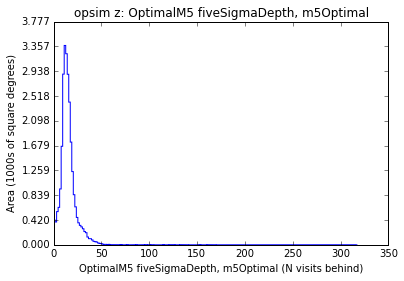

In [8]:
bundleDict = metricBundles.makeBundlesDictFromList(bundleList)
bgroup = metricBundles.MetricBundleGroup(bundleDict, opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()
bgroup.plotAll(closefigs=False)

In [9]:
# figure out median number of visits
bl = []
sql = 'filter="%s"' % filterName
metric = metrics.CountMetric(col='expMJD')
bl.append(metricBundles.MetricBundle(metric,slicer,'', summaryMetrics=summaryList))
bundleDict = metricBundles.makeBundlesDictFromList(bl)
bgroup = metricBundles.MetricBundleGroup(bundleDict, opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()

Querying database with no constraint.
Found 2447270 visits
Running:  ['opsim_Count_expMJD_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [10]:
print 'filter,  N-behind, %-behind'
totBehind = 0
for i,filtername in enumerate(filters):
    perbehind = bundleList[i*2+1].summaryValues['Median']
    nbehind  = bundleList[i*2].summaryValues['Median']
    totBehind += nbehind
    print '%s, %.1f, %.2f' % (filtername, nbehind, perbehind)
print '------'
print 'all filters, %.1f visits behind, median of %.1f visits per field' % (totBehind, bl[0].summaryValues['Median'])

filter,  N-behind, %-behind
u, 20.0, 27.20
g, 16.5, 18.02
r, 28.1, 13.39
i, 28.9, 13.73
z, 13.9, 7.22
y, 19.2, 9.51
------
all filters, 126.6 visits behind, median of 1091.0 visits per field
